In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from tqdm import tqdm


#sns.set(color_codes=True)

In [4]:
# Make proper file names for Windows
# pip install regex

import re

def windows_filename(s):
    s = str(s).strip().replace(' ', '_')
    return re.sub(r'(?u)[^-\w.]', '', s)

In [5]:
def plot_graph(plt,start_time, variable):
    plt.savefig(windows_filename(start_time)+'_' + variable+ '.pdf')    

In [6]:
def f2c(f):
    return (f - 32) * 5.0/9.0

In [4]:
from pathlib import Path

basePathPatrick = Path("C:/Users/pkastner/Google Drive/Patrick/OutdoorComfort-Biking/Measurements/")
basePathESL = Path("C:/Users/pkastner/Google Drive/Patrick/OutdoorComfort-Biking/Measurements/Remy/_Stations/")
basePathRemy = Path("C:/Users/remym/Dropbox/Cornell 2019-2020/ESL Independent Study/_Stations")
basePathRemy = Path("C:/Users/remym/Dropbox/Cornell 2019-2020/ESL Independent Study/_StationDataPython")
basePathBenj = Path("C:/Users/pkastner/Google Drive/Patrick/OutdoorComfort-Biking/Measurements/Benjamin_StationFile")

loadPath = basePathPatrick

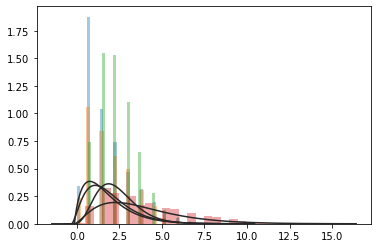

In [8]:
from hoboreader import HoboReader
S1=HoboReader(loadPath / "20191101_11-04_DL1.csv") 
S2=HoboReader(loadPath / "20191101-10-50_DL2.csv")
S3=HoboReader(loadPath / "20191115-11-08_DL3.csv")
S4=HoboReader(loadPath / "20191101-12-58_DL4.csv")


df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()

# Variable to plot
variable1 = "Wind Speed"
variable2 = "Wind Direction"

#df1[variable].hist()
sns.distplot(df1[variable1], kde=False, fit=stats.gamma);
sns.distplot(df2[variable1], kde=False, fit=stats.gamma);
sns.distplot(df3[variable1], kde=False, fit=stats.gamma);
sns.distplot(df4[variable1], kde=False, fit=stats.gamma);

#sns.jointplot(x=variable1, y=variable2, data=df1);

In [21]:
from windrose import WindroseAxes
from windrose import WindAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plotWR(ws, wd):
    ax = WindroseAxes.from_ax()
    ax.contourf(wd, ws, bins=np.arange(0, 6, 1),nsector= 36, cmap=cm.hot)
    ax.contour(wd, ws, bins=np.arange(0, 6, 1),nsector= 36, colors='black', lw=1)
    ax.set_legend()
    
def printPDF(ws):
    ax = WindAxes.from_ax()
    bins = np.arange(0, 6 + 1, 0.5)
    bins = bins[1:]
    ax, params = ax.pdf(ws, bins=bins)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\windrose\windrose.py:697: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bins = np.histogram(var, bins=bins, normed=True)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


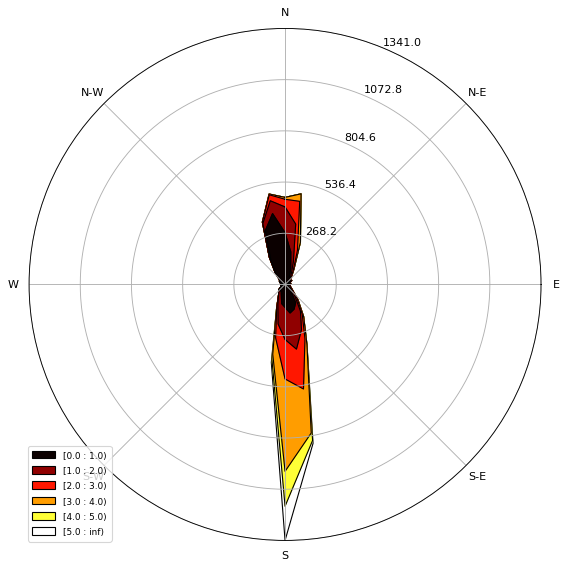

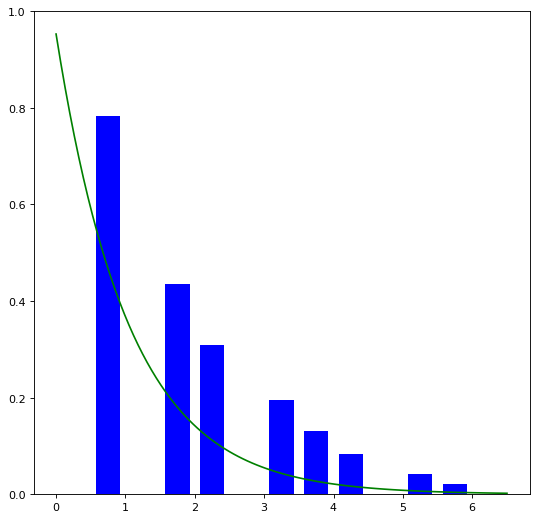

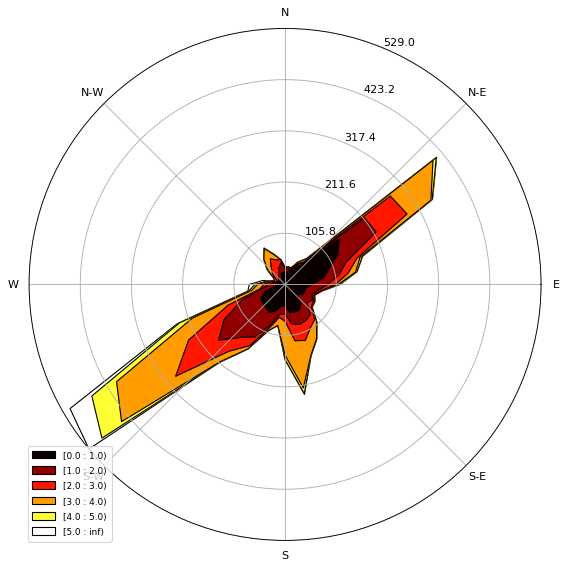

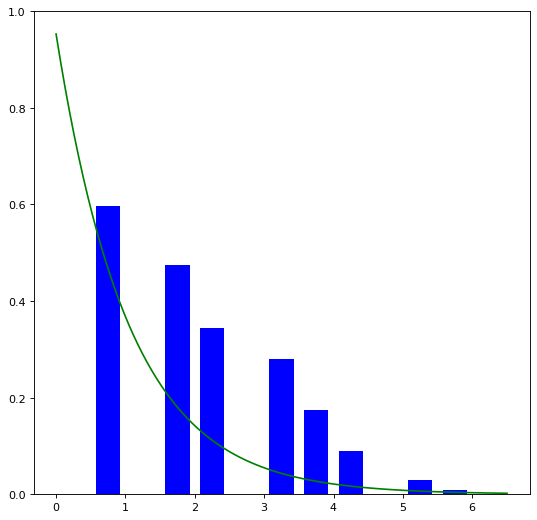

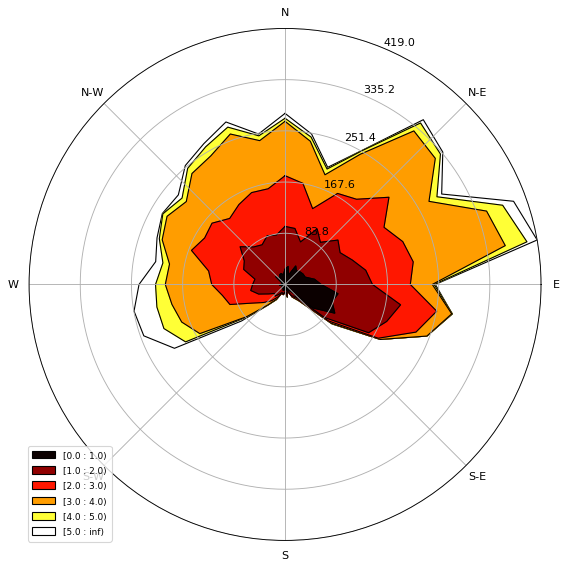

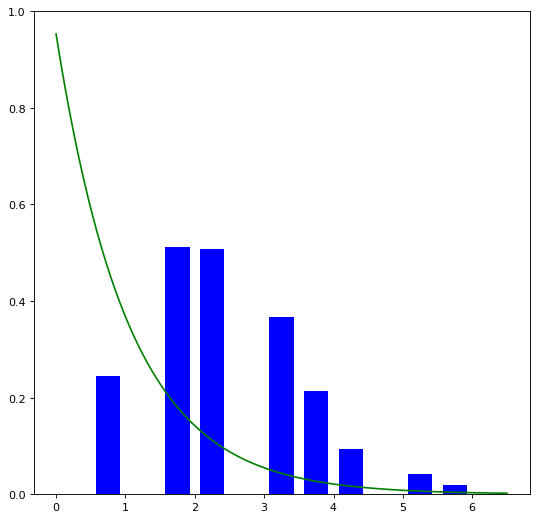

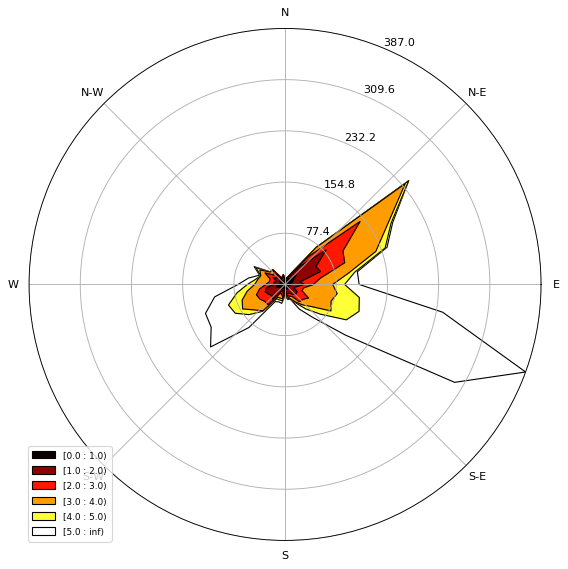

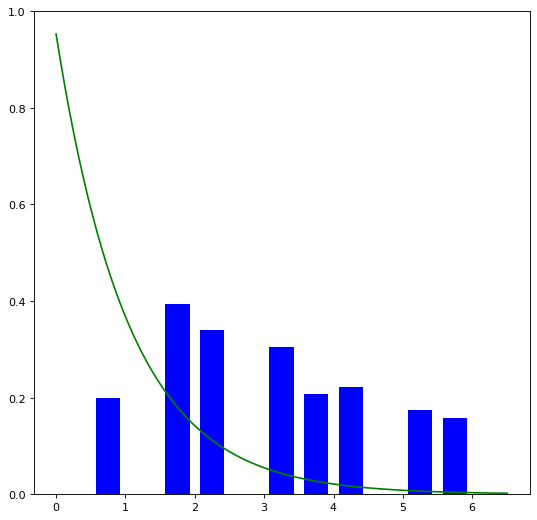

In [22]:


list = [df1, df2, df3, df4]

# Variable to plot
variable1 = "Wind Speed"
variable2 = "Wind Direction"

ws = np.array(df1[variable1]).flatten()
wd = np.array(df1[variable2]).flatten()

for i in tqdm(list):
    ws = np.array(i[variable1]).flatten()
    wd = np.array(i[variable2]).flatten()
    plotWR(ws, wd)
    printPDF(ws)
    
     
    


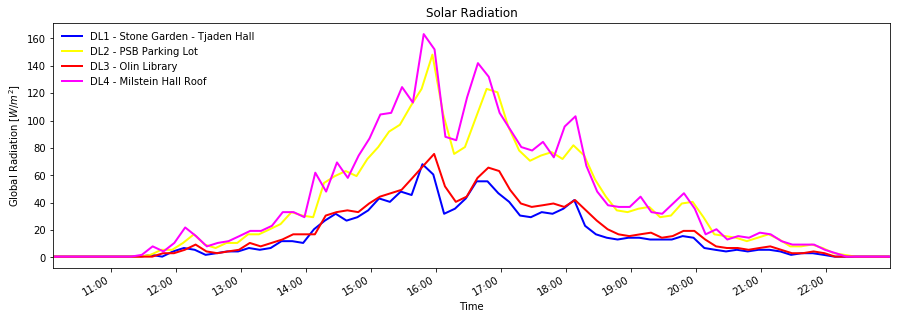

In [5]:
from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path

      
    
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   
  
    
S1=HoboReader(loadPath / "20191101_11-04_DL1.csv") 
S2=HoboReader(loadPath / "20191101-10-50_DL2.csv")
S3=HoboReader(loadPath / "20191115-11-08_DL3.csv")
S4=HoboReader(loadPath / "20191101-12-58_DL4.csv")


df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()

# Select time

start_time = '2019-10-17 06:00:00-04:00'
end_time = '2019-10-17 19:00:00-04:00'

df1_ = df1.loc[start_time:end_time]
df2_ = df2.loc[start_time:end_time]
df3_ = df3.loc[start_time:end_time]
df4_ = df4.loc[start_time:end_time]

#df1.index

# Print Headers
#print(df1.columns.values)


# Resize figure
custom_figsize=(15,5)

# Change lineweights
lineweights = 2

# Variable to plot
variable = 'Solar Radiation'

# Plot two dataframes into one plot
ax = df1_.plot(y=[variable],lw = lineweights, figsize=custom_figsize,color='blue')
df3_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='yellow',ax=ax)
df2_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='red',ax=ax)
df4_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='magenta',ax=ax)

# Subset Time Series By Dates Python Using Pandas
#https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/


# Legend
ax.legend([
"DL1 - Stone Garden - Tjaden Hall", 
"DL2 - PSB Parking Lot",
"DL3 - Olin Library",
"DL4 - Milstein Hall Roof "  
],loc='upper left', frameon=False)


# Fix xticks

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every minute
hours = mdates.HourLocator()  # every minute
minutes = mdates.MinuteLocator()  # every minute

days_fmt = mdates.DateFormatter('%d')
hours_fmt = mdates.DateFormatter('%H:00')

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_minor_locator(hours)

#Labels
plt.ylabel('Global Radiation $[W/m^2]$')
plt.xlabel("Time")
     
# Title
ax.set_title(variable)

# Save PDF
plot_graph(plt, start_time, variable)

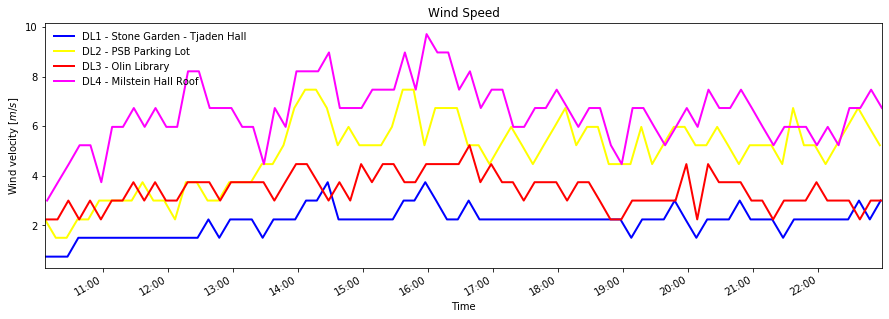

In [6]:
from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
     
    
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   
  
    
S1=HoboReader(loadPath / "20191101_11-04_DL1.csv") 
S2=HoboReader(loadPath / "20191101-10-50_DL2.csv")
S3=HoboReader(loadPath / "20191115-11-08_DL3.csv")
S4=HoboReader(loadPath / "20191101-12-58_DL4.csv")


df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()

# Select time

start_time = '2019-10-17 06:00:00-04:00'
end_time = '2019-10-17 19:00:00-04:00'

df1_ = df1.loc[start_time:end_time]
df2_ = df2.loc[start_time:end_time]
df3_ = df3.loc[start_time:end_time]
df4_ = df4.loc[start_time:end_time]

#df1.index

# Print Headers
#print(df1.columns.values)


# Resize figure
custom_figsize=(15,5)

# Change lineweights
lineweights = 2

# Variable to plot
variable = "Wind Speed"

# Plot two dataframes into one plot
ax = df1_.plot(y=[variable],lw = lineweights, figsize=custom_figsize,color='blue')
df3_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='yellow',ax=ax)
df2_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='red',ax=ax)
df4_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='magenta',ax=ax)

# Subset Time Series By Dates Python Using Pandas
#https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/


# Legend
ax.legend([
"DL1 - Stone Garden - Tjaden Hall", 
"DL2 - PSB Parking Lot",
"DL3 - Olin Library",
"DL4 - Milstein Hall Roof "  
],loc='upper left', frameon=False)


# Fix xticks

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every minute
hours = mdates.HourLocator()  # every minute
minutes = mdates.MinuteLocator()  # every minute

days_fmt = mdates.DateFormatter('%d')
hours_fmt = mdates.DateFormatter('%H:00')

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_minor_locator(hours)

#Labels
plt.ylabel('Wind velocity $[m/s]$')
plt.xlabel("Time")
     
# Title
ax.set_title(variable)

# Save PDF
plot_graph(plt, start_time, variable)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C50CA77E08>,
      dtype=object)

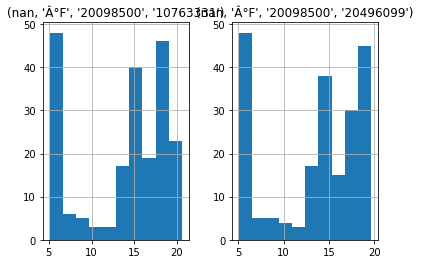

In [ ]:
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   


#"#","Date Time, GMT-04:00",
#"Temp, °F (LGR S/N: 20702490, SEN S/N: 20496098, LBL: MRT)",
#"Temp, °F (LGR S/N: 20702490, SEN S/N: 20698454, LBL: Drybulb)",
#"RH, % (LGR S/N: 20702490, SEN S/N: 20698454)",
#"Solar Radiation, W/m² (LGR S/N: 20702490, SEN S/N: 20702165, LBL: Rad)",
#"Wind Speed, mph (LGR S/N: 20702490, SEN S/N: 20706788, LBL: Wind)",
#"Gust Speed, mph (LGR S/N: 20702490, SEN S/N: 20706788)",
#"Wind Direction, ø (LGR S/N: 20702490, SEN S/N: 20706788)",
#"DewPt, °F (LGR S/N: 20702490, SEN S/N: 20698454)"
    

S4=HoboReader(loadPath / "20191101-12-58_DL4.csv")


df4=S4.get_dataframe()

# Select time

start_time = '2019-09-01 06:00:00-04:00'
end_time = '2019-12-15 19:00:00-04:00'


df4_ = df4.loc[start_time:end_time]

# Resize figure
custom_figsize=(25,5)

# Change lineweights
lineweights = 2


# Variable to plot
variable = "Temp"
variable2 = "Temp"


test= df4_[variable].subtract(df4_[variable2], fill_value=0)


print(test)


# Plot two dataframes into one plot
#ax = plt.plot(diff,lw = lineweights, figsize=custom_figsize,color='blue')
#
## Subset Time Series By Dates Python Using Pandas
##https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/
#
## Legend
#ax.legend([
#"DL1 - Stone Garden - Tjaden Hall", 
#"DL2 - PSB Parking Lot",
#"DL3 - Olin Library",
#"DL4 - Milstein Hall Roof "  
#],loc='upper left', frameon=False)
#
## Fix xticks
#
#years = mdates.YearLocator()   # every year
#months = mdates.MonthLocator()  # every month
#days = mdates.DayLocator()  # every minute
#hours = mdates.HourLocator()  # every minute
#minutes = mdates.MinuteLocator()  # every minute
#
#days_fmt = mdates.DateFormatter('%d')
#hours_fmt = mdates.DateFormatter('%H:00')
#
## format the ticks
#ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(hours_fmt)
#ax.xaxis.set_minor_locator(hours)
#
##Labels
#plt.ylabel('Wind velocity $[m/s]$')
#plt.xlabel("Time")
#     
## Title
#ax.set_title(variable)

In [ ]:
from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path

    
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   
  
    
S1=HoboReader(loadPath / "20191101_11-04_DL1.csv") 
S2=HoboReader(loadPath / "20191101-10-50_DL2.csv")
S3=HoboReader(loadPath / "20191115-11-08_DL3.csv")
S4=HoboReader(loadPath / "20191101-12-58_DL4.csv")


df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()

# Select time

start_time = '2019-10-17 06:00:00-04:00'
end_time = '2019-10-17 19:00:00-04:00'

df1_ = df1.loc[start_time:end_time]
df2_ = df2.loc[start_time:end_time]
df3_ = df3.loc[start_time:end_time]
df4_ = df4.loc[start_time:end_time]

#df1.index

# Print Headers
#print(df1.columns.values)


# Resize figure
custom_figsize=(15,5)

# Change lineweights
lineweights = 2

# Variable to plot
variable = "Wind Direction"

# Plot two dataframes into one plot
ax = df1_.plot(y=[variable],lw = lineweights, figsize=custom_figsize,color='blue')
df3_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='yellow',ax=ax)
df2_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='red',ax=ax)
df4_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='magenta',ax=ax)

# Subset Time Series By Dates Python Using Pandas
#https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/


# Legend
ax.legend([
"DL1 - Stone Garden - Tjaden Hall", 
"DL2 - PSB Parking Lot",
"DL3 - Olin Library",
"DL4 - Milstein Hall Roof "  
],loc='upper left', frameon=False)


# Fix xticks

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every minute
hours = mdates.HourLocator()  # every minute
minutes = mdates.MinuteLocator()  # every minute

days_fmt = mdates.DateFormatter('%d')
hours_fmt = mdates.DateFormatter('%H:00')

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_minor_locator(hours)

#Labels
plt.ylabel('Wind direction $[°]$')
plt.xlabel("Time")
     
# Title
ax.set_title(variable)

# Save PDF
plot_graph(plt, start_time, variable)

In [ ]:
# conda install -c https://conda.anaconda.org/ioos geopandas
# conda install -c conda-forge shapely
# conda install -c conda-forge descartes

import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

#final_crs = {'init': 'epsg:28992'}

buildings = gpd.read_file('Ithaca/map/buildings-polygon.shp')#.to_crs(final_crs)
roads = gpd.read_file('Ithaca/map/roads-line.shp')#.to_crs(final_crs)
landcover = gpd.read_file('Ithaca/map/landcover-polygon.shp')#.to_crs(final_crs)
water = gpd.read_file('Ithaca/map/water_areas-polygon.shp')#.to_crs(final_crs)
waterlines = gpd.read_file('Ithaca/map/water_lines-line.shp')#.to_crs(final_crs)

fig,ax = plt.subplots(figsize= (10,10))

roads.plot(ax=ax, color= "grey")
landcover.plot(ax=ax, color= "green", alpha=0.03)
water.plot(ax=ax, color= "blue", alpha=0.1)
waterlines.plot(ax=ax, color= "blue", alpha=0.1)
buildings.plot(ax=ax, color= "black")

minx, miny, maxx, maxy = -76.4900, 42.443484, -76.475089, 42.4555
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

DL1= Point((-76.485089,42.450960))
DL2= Point((-76.481194,42.450536))
DL3= Point((-76.484268,42.448039))
DL4= Point((-76.483743,42.451245))

gdf_stations = gpd.GeoSeries([DL1,DL2,DL3,DL4])
gdf_stations.plot(ax=ax, markersize= 50, color= "red", marker = "o")

# Annotate with names

stations = [
"DL1", 
"DL2",
"DL3",
"DL4"  
]
xx = 0.0003
yy = 0.0001

for i, geo in gdf_stations.centroid.iteritems():
    ax.annotate(s=stations[i], xy=[geo.x+xx, geo.y-yy], color="red" )


# Save PDF
plt.savefig('Map.pdf')

In [ ]:
from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path


    
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   
  
    
S1=HoboReader(basePathPatrick / "20191101_11-04_DL1.csv") 
S2=HoboReader(basePathPatrick / "20191101-10-50_DL2.csv")
S3=HoboReader(basePathPatrick / "20191115-11-08_DL3.csv")
S4=HoboReader(basePathPatrick / "20191101-12-58_DL4.csv")


df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()

# Select time

start_time = '2019-10-31 00:00:00-04:00'
end_time = '2019-11-01 23:59:00-04:00'

df1_ = df1.loc[start_time:end_time]
df2_ = df2.loc[start_time:end_time]
df3_ = df3.loc[start_time:end_time]
df4_ = df4.loc[start_time:end_time]

#df1.index

# Print Headers
#print(df1.columns.values)


# Resize figure
custom_figsize=(40,15)

# Change lineweights
lineweights = 1.5

# Variable to plot
variable = "Wind Direction"

# Plot two dataframes into one plot
ax = df1_.plot(y=[variable],lw = lineweights, figsize=custom_figsize,color='red')
df3_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='blue',ax=ax)
df2_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='green',ax=ax)
df4_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='aqua',ax=ax)

# Subset Time Series By Dates Python Using Pandas
#https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/


# Legend
ax.legend([
"DL1 - Stone Garden - Tjaden Hall", 
"DL2 - PSB Parking Lot",
"DL3 - Olin Library",
"DL4 - Milstein Hall Roof "  
],loc='upper left', frameon=False)


# Fix xticks

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every minute
hours = mdates.HourLocator()  # every minute
minutes = mdates.MinuteLocator()  # every minute

days_fmt = mdates.DateFormatter('%d')
hours_fmt = mdates.DateFormatter('%H:00')

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_minor_locator(hours)

#Labels
plt.ylabel('Wind direction $[°]$', fontname="Consolas", fontsize=20)
plt.xlabel("Time", fontname="Consolas", fontsize=20)
     
# Title
ax.set_title(variable, fontname="Consolas", fontsize=28)

# Save PDF
plot_graph(plt, start_time, variable)

In [ ]:
from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path


      
    
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   
  
    
S1=HoboReader(basePathPatrick/ "20191101_11-04_DL1.csv") 
S2=HoboReader(basePathPatrick/ "20191101-10-50_DL2.csv")
S3=HoboReader(basePathPatrick/ "20191115-11-08_DL3.csv")
S4=HoboReader(basePathPatrick/ "20191101-12-58_DL4.csv")


df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()

# Select time

start_time = '2019-10-31 00:00:00-04:00'
end_time = '2019-11-01 23:59:00-04:00'

df1_ = df1.loc[start_time:end_time]
df2_ = df2.loc[start_time:end_time]
df3_ = df3.loc[start_time:end_time]
df4_ = df4.loc[start_time:end_time]

#df1.index

# Print Headers
#print(df1.columns.values)


# Resize figure
custom_figsize=(40,15)

# Change lineweights
lineweights = 1.5

# Variable to plot
variable = "Wind Speed"

# Plot two dataframes into one plot
ax = df1_.plot(y=[variable],lw = lineweights, figsize=custom_figsize,color='red')
df3_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='blue',ax=ax)
df2_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='green',ax=ax)
df4_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='aqua',ax=ax)

# Subset Time Series By Dates Python Using Pandas
#https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/


# Legend
ax.legend([
"DL1 - Stone Garden - Tjaden Hall", 
"DL2 - PSB Parking Lot",
"DL3 - Olin Library",
"DL4 - Milstein Hall Roof "  
],loc='upper left', frameon=False)


# Fix xticks

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every minute
hours = mdates.HourLocator()  # every minute
minutes = mdates.MinuteLocator()  # every minute

days_fmt = mdates.DateFormatter('%d')
hours_fmt = mdates.DateFormatter('%H:00')

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_minor_locator(hours)

#Labels
plt.ylabel('Wind Speed $[MPH]$', fontname="Consolas", fontsize=20)
plt.xlabel("Time", fontname="Consolas", fontsize=20)
     
# Title
ax.set_title(variable, fontname="Consolas", fontsize=28)

# Save PDF
plot_graph(plt, start_time, variable)

In [ ]:
from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path


    
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   
  
    
S1=HoboReader(basePathPatrick / "20191101_11-04_DL1.csv") 
S2=HoboReader(basePathPatrick / "20191101-10-50_DL2.csv")
S3=HoboReader(basePathPatrick / "20191115-11-08_DL3.csv")
S4=HoboReader(basePathPatrick / "20191101-12-58_DL4.csv")


df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()

# Select time

start_time = '2019-10-31 00:00:00-04:00'
end_time = '2019-11-01 23:59:00-04:00'

df1_ = df1.loc[start_time:end_time]
df2_ = df2.loc[start_time:end_time]
df3_ = df3.loc[start_time:end_time]
df4_ = df4.loc[start_time:end_time]

#df1.index

# Print Headers
#print(df1.columns.values)


# Resize figure
custom_figsize=(40,15)

# Change lineweights
lineweights = 2

# Variable to plot
variable = 'Solar Radiation'

# Plot two dataframes into one plot
ax = df1_.plot(y=[variable],lw = lineweights, figsize=custom_figsize,color='red')
df3_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='blue',ax=ax)
df2_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='green',ax=ax)
df4_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='aqua',ax=ax)

# Subset Time Series By Dates Python Using Pandas
#https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/


# Legend
ax.legend([
"DL1 - Stone Garden - Tjaden Hall", 
"DL2 - PSB Parking Lot",
"DL3 - Olin Library",
"DL4 - Milstein Hall Roof "  
],loc='upper left', frameon=False)


# Fix xticks

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every minute
hours = mdates.HourLocator()  # every minute
minutes = mdates.MinuteLocator()  # every minute

days_fmt = mdates.DateFormatter('%d')
hours_fmt = mdates.DateFormatter('%H:00')

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_minor_locator(hours)

#Labels
plt.ylabel('Global Radiation $[W/m^2]$', fontname="Consolas", fontsize=20)
plt.xlabel("Time", fontname="Consolas", fontsize=20)
     
# Title
ax.set_title(variable, fontname="Consolas", fontsize=28)

# Save PDF
plot_graph(plt, start_time, variable)

C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pkastner\Anaconda3\envs\hobo\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

NameError: name 'plot_graph' is not defined

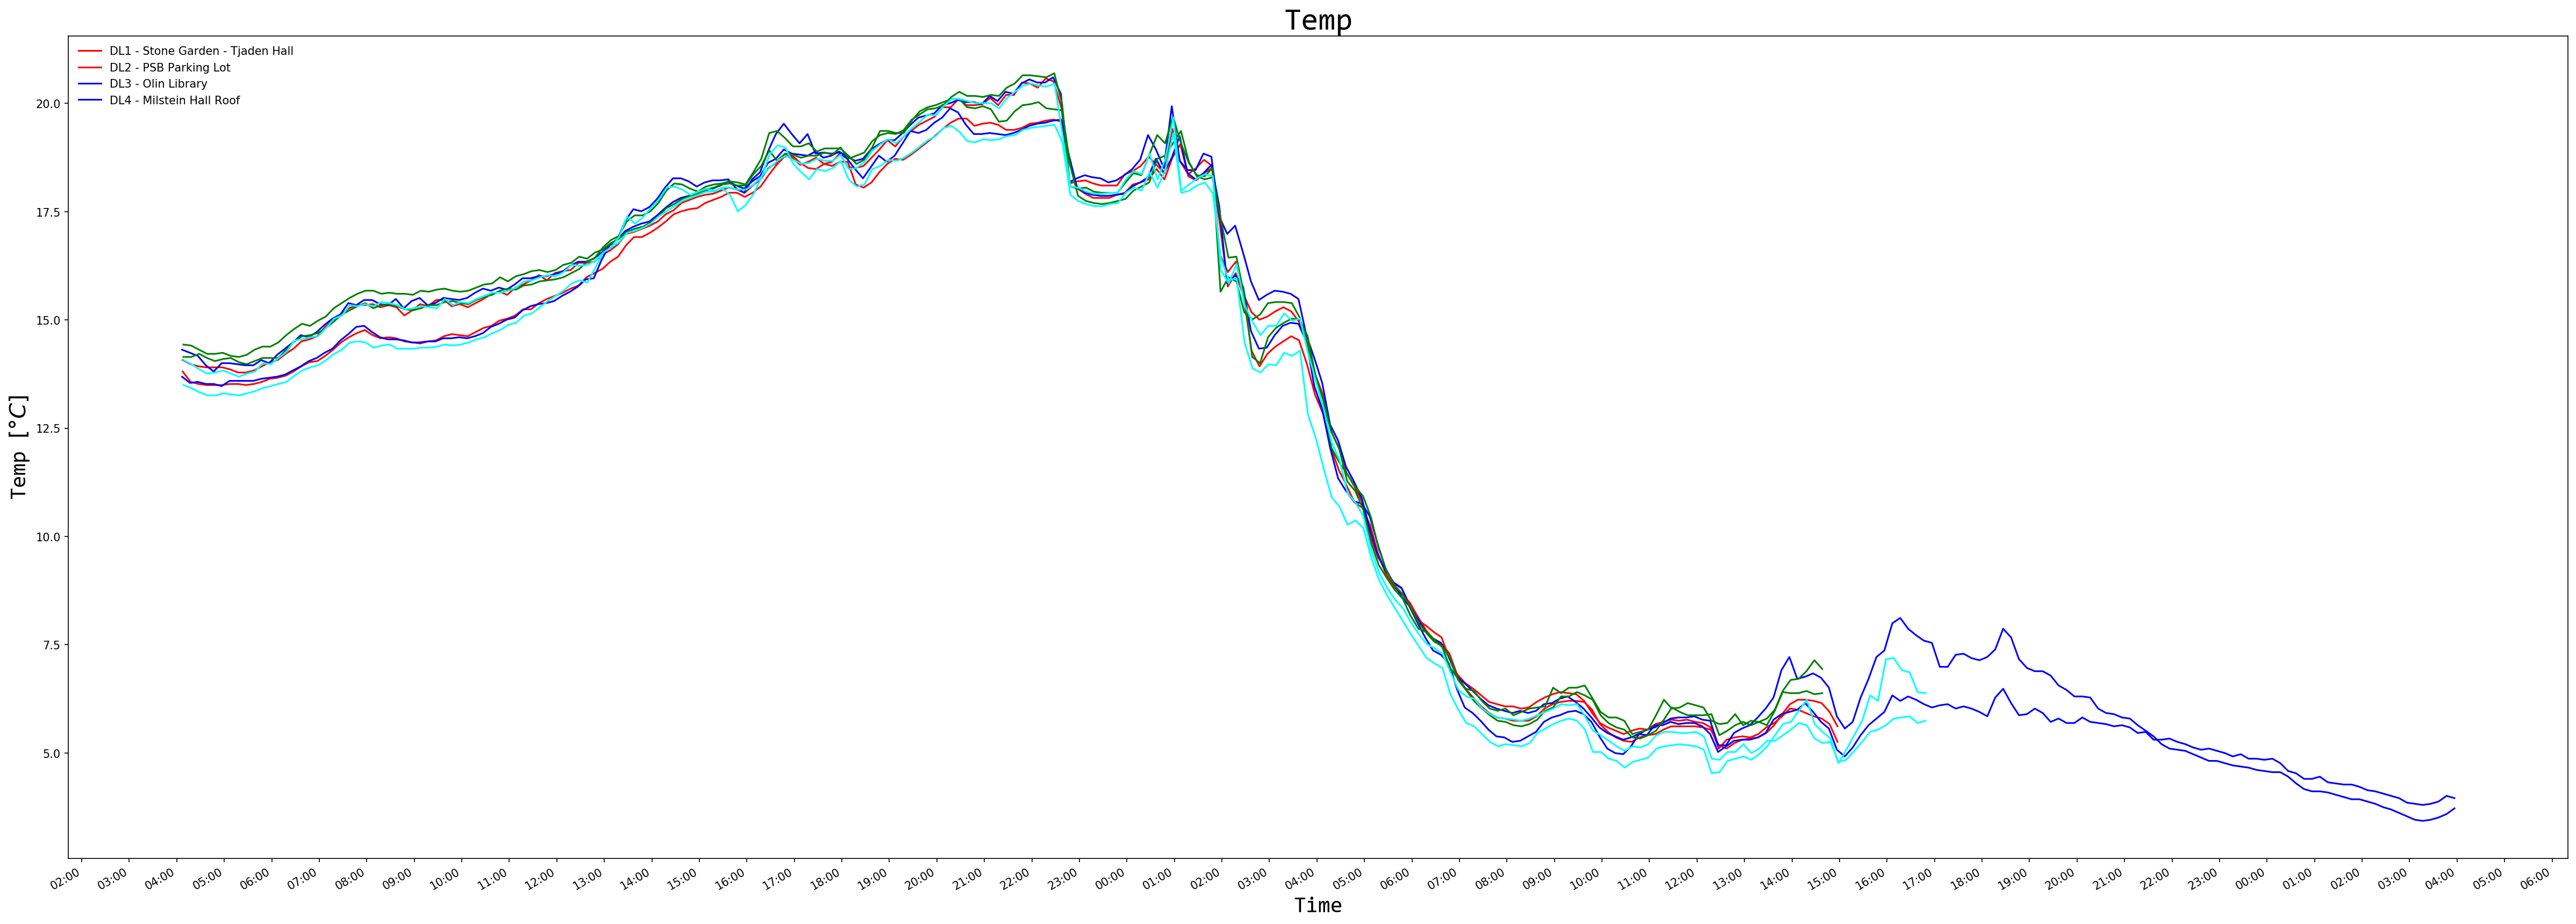

In [57]:
from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path


    
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   
  
    
S1=HoboReader(basePathPatrick / "20191101_11-04_DL1.csv") 
S2=HoboReader(basePathPatrick / "20191101-10-50_DL2.csv")
S3=HoboReader(basePathPatrick / "20191115-11-08_DL3.csv")
S4=HoboReader(basePathPatrick / "20191101-12-58_DL4.csv")


df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()

# Select time

start_time = '2019-10-31 00:00:00-04:00'
end_time = '2019-11-01 23:59:00-04:00'

df1_ = df1.loc[start_time:end_time]
df2_ = df2.loc[start_time:end_time]
df3_ = df3.loc[start_time:end_time]
df4_ = df4.loc[start_time:end_time]

#df1.index

# Print Headers
#print(df1.columns.values)


# Resize figure
custom_figsize=(40,15)

# Change lineweights
lineweights = 1.5

# Variable to plot
variable = "Temp"

# Translate to °C

df1_[variable] = df1_[variable].apply(lambda x: f2c(x), axis=1)
df2_[variable] = df2_[variable].apply(lambda x: f2c(x), axis=1)
df3_[variable] = df3_[variable].apply(lambda x: f2c(x), axis=1)
df4_[variable] = df4_[variable].apply(lambda x: f2c(x), axis=1)


# Plot two dataframes into one plot
ax = df1_.plot(y=[variable],lw = lineweights, figsize=custom_figsize,color='red')
df3_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='blue',ax=ax)
df2_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='green',ax=ax)
df4_.plot(     y=[variable],lw = lineweights, figsize=custom_figsize,color='aqua',ax=ax)

# Subset Time Series By Dates Python Using Pandas
#https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/


# Legend
ax.legend([
"DL1 - Stone Garden - Tjaden Hall", 
"DL2 - PSB Parking Lot",
"DL3 - Olin Library",
"DL4 - Milstein Hall Roof "  
],loc='upper left', frameon=False)


# Fix xticks

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every minute
hours = mdates.HourLocator()  # every minute
minutes = mdates.MinuteLocator()  # every minute

days_fmt = mdates.DateFormatter('%d')
hours_fmt = mdates.DateFormatter('%H:00')

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_minor_locator(hours)

#Labels
plt.ylabel('Temp $[°C]$', fontname="Consolas", fontsize=20)
plt.xlabel("Time", fontname="Consolas", fontsize=20)
     
# Title
ax.set_title(variable, fontname="Consolas", fontsize=28)

# Save PDF
plot_graph(plt, start_time, variable)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

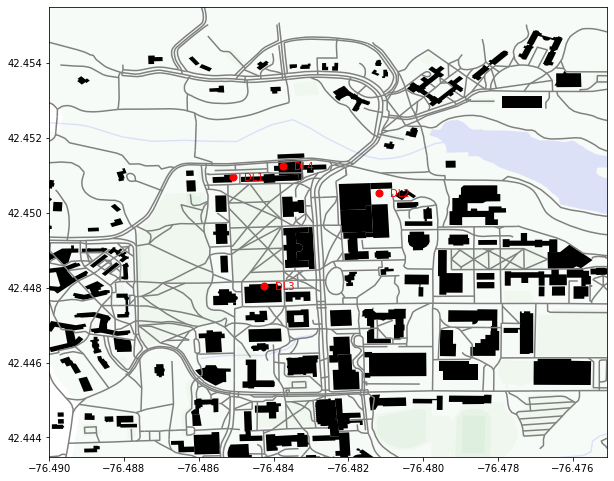

In [2]:
# conda install -c https://conda.anaconda.org/ioos geopandas
# conda install -c conda-forge shapely
# conda install -c conda-forge descartes

import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

#final_crs = {'init': 'epsg:28992'}

buildings = gpd.read_file('Ithaca/map/buildings-polygon.shp')#.to_crs(final_crs)
roads = gpd.read_file('Ithaca/map/roads-line.shp')#.to_crs(final_crs)
landcover = gpd.read_file('Ithaca/map/landcover-polygon.shp')#.to_crs(final_crs)
water = gpd.read_file('Ithaca/map/water_areas-polygon.shp')#.to_crs(final_crs)
waterlines = gpd.read_file('Ithaca/map/water_lines-line.shp')#.to_crs(final_crs)

fig,ax = plt.subplots(figsize= (10,10))

roads.plot(ax=ax, color= "grey")
landcover.plot(ax=ax, color= "green", alpha=0.03)
water.plot(ax=ax, color= "blue", alpha=0.1)
waterlines.plot(ax=ax, color= "blue", alpha=0.1)
buildings.plot(ax=ax, color= "black")

minx, miny, maxx, maxy = -76.4900, 42.443484, -76.475089, 42.4555
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

DL1= Point((-76.485089,42.450960))
DL2= Point((-76.481194,42.450536))
DL3= Point((-76.484268,42.448039))
DL4= Point((-76.483743,42.451245))

gdf_stations = gpd.GeoSeries([DL1,DL2,DL3,DL4])
gdf_stations.plot(ax=ax, markersize= 50, color= "red", marker = "o")

# Annotate with names

stations = [
"DL1", 
"DL2",
"DL3",
"DL4"  
]
xx = 0.0003
yy = 0.0001

for i, geo in gdf_stations.centroid.iteritems():
    ax.annotate(s=stations[i], xy=[geo.x+xx, geo.y-yy], color="red" )


# Save PDF
plt.savefig('Map.pdf')

In [3]:
# Merge all recorded data


from hoboreader import HoboReader
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

# Set up figure size and DPI for screen demo
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 150





loadPath = Path(r"C:\Users\remym\Dropbox\ESL\CSV Merged Data")
    
#DL1	Stone Garden - Tjaden Hall
#DL2	PSB Parking Lot
#DL3	Olin Library
#DL4	Milstein Hall Roof   
  
    
S1=HoboReader(loadPath / "DL1_Stone_Garden_Tjaden_Hall.csv") 
S2=HoboReader(loadPath / "DL2_PSB_Parking_Lot.csv")
S3=HoboReader(loadPath / "DL3_Olin_Library.csv")
S4=HoboReader(loadPath / "DL4_Milstein_Hall_Roof.csv")

df1=S1.get_dataframe()
df2=S2.get_dataframe()
df3=S3.get_dataframe()
df4=S4.get_dataframe()


def f(variable_id,d, m,y):
            
    start_time = str(y)+'-'+str(m)+'-'+str(d)+' 07:00:00-00:00'
    end_time =   str(y)+'-'+str(m)+'-'+str(d)+' 23:00:00-00:00'
    
   
    df1_ = df1.loc[start_time:end_time]
    df2_ = df2.loc[start_time:end_time]
    df3_ = df3.loc[start_time:end_time]
    df4_ = df4.loc[start_time:end_time]
    
    #df1.index
    
    # Print Headers
    #print(df1.columns.values)
    
    
    # Resize figure
    custom_figsize=(20,10)
    
    # Change lineweights
    lineweights = 1.5
    
    variables = ["Wind Speed","MRT","Temp","RH","Solar Radiation","Wind Speed","Gust Speed","Wind Direction","DewPt" ]  
    
    
    
    variable = variables[variable_id]


    # Plot two dataframes into one plot
    ax = df1_.plot(y = variable, lw = lineweights, figsize=custom_figsize,color='red')
    df2_.plot( y = variable,    lw = lineweights, figsize=custom_figsize,color='blue',ax=ax)
    df3_.plot(y = variable,     lw = lineweights, figsize=custom_figsize,color='green',ax=ax)
    df4_.plot(y = variable,     lw = lineweights, figsize=custom_figsize,color='aqua',ax=ax)
    
    # Legend
    ax.legend([
    "DL1 - Stone Garden - Tjaden Hall", 
    "DL2 - PSB Parking Lot",
    "DL3 - Olin Library",
    "DL4 - Milstein Hall Roof "  
    ],loc='upper left', frameon=False)
    
    
    # Fix xticks
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator()  # every minute
    hours = mdates.HourLocator()  # every minute
    minutes = mdates.MinuteLocator()  # every minute
    
    days_fmt = mdates.DateFormatter('%d')
    hours_fmt = mdates.DateFormatter('%H:00')
    
    # format the ticks
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(hours_fmt)
    ax.xaxis.set_minor_locator(hours)
    
    #Labels
    plt.ylabel(variable, fontname="Consolas", fontsize=20)
    plt.xlabel("Time", fontname="Consolas", fontsize=20)
         
    # Title
    ax.set_title(str(start_time.split(' ')[0]+" "+variable), fontname="Consolas", fontsize=28)
    
    # Save PDF
    #plot_graph(plt, start_time, variable)

    
# Variable to plot
#1 = "MRT"
#2 = "Temp"
#3 = "RH"
#4 = "Solar Radiation"
#5 = "Wind Speed"
#6 = "Gust Speed"
#7 = "Wind Direction"
#8 = "DewPt"
    
    
interact(f,variable_id=(1,8,1), d=(1,31,1), m=(1,12,1), y = (2019,2020,1))










interactive(children=(IntSlider(value=4, description='variable_id', max=8, min=1), IntSlider(value=16, descrip…

<function __main__.f(variable_id, d, m, y)>

In [3]:
## Import libraries and check the versions
#import pandas as pd
#import sys
#import missingno as msno
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib
#import pandas_profiling
from datetime import date
#from hoboreader import HoboReader
#
#%matplotlib inline
#print('Python version ' + sys.version)
#print('Numpy version ' + np.__version__)
#print('Pandas version ' + pd.__version__)
#print('Matplotlib version ' + matplotlib.__version__ )
#print('Missingno version ' + msno.__version__)


S1=HoboReader(loadPath / "DL1_Stone_Garden_Tjaden_Hall.csv") 
#S2=HoboReader(loadPath / "DL2_PSB_Parking_Lot.csv")
#S3=HoboReader(loadPath / "DL3_Olin_Library.csv")
#S4=HoboReader(loadPath / "DL4_Milstein_Hall_Roof.csv")

df1=S1.get_dataframe()
#df2=S2.get_dataframe()
#df3=S3.get_dataframe()
#df4=S4.get_dataframe()





begin = datetime.date(2019, 9, 15)
end = datetime.date(2020, 5, 15)
idx = pd.period_range(begin, end, freq='H')
idx

#msno.matrix(df1.set_index(pd.period_range('1/1/2019', '2/1/2020', freq='D')) , freq='BQ')

#idx = pd.period_range(min(df1['Date Time']), max(df1['Date Time']))

#print(idx)
#df1.reindex(idx, fill_value=0)


#print(df1)

#null_pattern = (np.random.random(1000).reshape((50, 20)) > 0.5).astype(bool)
#null_pattern = pd.DataFrame(null_pattern).replace({False: None})
#msno.matrix(null_pattern.set_index(pd.period_range('1/1/2011', '2/1/2015', freq='M')) , freq='BQ')

NameError: name 'HoboReader' is not defined